In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow import keras
import os
from sklearn import model_selection
from sklearn import utils
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score
from scipy import ndimage
from gc import collect
import matplotlib.pyplot as plt
from collections import Counter
from seaborn import heatmap


In [ ]:
def get_labels(label_file):
    """lê a tabela com as informações dos pacientes e retorna uma matriz com o ID e as labels"""
    labels = pd.read_csv(label_file)
    cancer_labels = dict()

    for p in labels.index:
        cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

    return cancer_labels

In [ ]:
labels = get_labels('/kaggle/input/labelsssss/labels.csv')
numbers_per_class = [0, 0, 0, 0]
for i in labels:
    numbers_per_class[np.argmax(labels[i])] += 1

proportion_per_class = [round(number_of_class/sum(numbers_per_class), 2) for number_of_class in numbers_per_class]
proportion_per_class

[0.35, 0.25, 0.23, 0.17]

In [ ]:
path = '/kaggle/input/192x256xdepth/'
dirs = os.listdir(path)

X = [path + i for i in os.listdir(path)]
y = [np.argmax(labels[(path+i)[-14:-4]]) for i in os.listdir(path)]

In [ ]:
def balancing_batch(X, y, max_value):
    numbers_per_class = sorted(Counter(y).items())

    if len(numbers_per_class) == 1:
        return X[0:1], y[0:1] #return only the first image because the batch has only one class

    if numbers_per_class[0][1] > numbers_per_class[1][1]:
        max_per_class = numbers_per_class[1][1]
    else:
        max_per_class = numbers_per_class[0][1]

    if max_per_class > max_value//2:
        max_per_class = max_value//2

    X, y = utils.shuffle(X, y)
    new_X, new_y = [], []
    counter_class_zero = 0
    counter_class_one = 0
    for test_x, test_y in zip(X, y):
        if test_y == 0 and counter_class_zero < max_per_class//2:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_zero += 1
        elif test_y == 1 and counter_class_one < max_per_class//2:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_one += 1

    return np.array(new_X, dtype='float16'), np.array(new_y, dtype='float16')

In [ ]:
def separate_slices(img):
    'function to separate 2d images of 3d original image'
    slices = []

    for i in range(img.shape[-2]):
        slices.append(np.array(img[:, :, i]))

    slices.append(np.mean(img, axis=-2)) #including mean of slices

    return slices

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y,random_state=42, train_size=0.8)

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, objective, list_IDs, labels_dir, batch_size, sub_batch_size, dim_img, training, shuffle=True):
        self.objective = objective # list representing one hot encoding for choice label ([1, 0, 0, 0] for normal, [0, 0, 0, 1] for cancer ..)
        self.list_IDs = list_IDs # array of strings with original images name with directory
        self.labels = self.__get_labels(labels_dir) #dict with labels of all images
        self.batch_size = batch_size #3d-images per batch
        self.sub_batch_size = sub_batch_size #quantity of sub-images per batch will be choose to train
        self.dim_img = dim_img # tuple with width and height of image like (192, 256)
        self.training = training # true if generator is for training, false if generator is for validation
        self.shuffle = shuffle # true or false to shuffle data after any epochs
        self.on_epoch_end() # call of the function

    def __get_labels(self, label_file):
        'take the dict with labels of images'
        labels = pd.read_csv(label_file)
        cancer_labels = dict()

        for p in labels.index:
            cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

        return cancer_labels

    def __data_augmentation(self, x):
        'generate variations of images'
        new_images = []
        x = x.astype('float16')
        new_images.append(x)

        x = cv2.flip(x.astype('float32'), 1).astype('float16')

        new_images.append(np.expand_dims(x, -1))

        return utils.shuffle(new_images)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        if self.training:
            X, y = balancing_batch(X, y, self.sub_batch_size)
            return np.array(X[0:self.sub_batch_size], dtype='float16'), np.array(y[0:self.sub_batch_size], dtype='uint8')

        return np.array(X), np.array(y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            prev_len_X = len(X)
            full_image = np.load(ID)
            new_images = separate_slices(full_image)
            if self.training:
                for img in new_images:
                    X += self.__data_augmentation(img)
            else:
                X = np.array(new_images, dtype='float16')

            #adding new data labels for y array
            for _ in range(len(X) - prev_len_X):
                if self.labels[ID[-14:-4]] == self.objective: #'-14:-4 represent a part of string with name of original image that slices was taken'
                    y.append(1)
                else:
                    y.append(0)

        X, y = utils.shuffle(X, y)
        return X, y

In [ ]:
def get_vgg19():
    return tf.keras.Sequential([tf.keras.layers.Conv2D(filters=32, kernel_size=(6, 8),
                                                       use_bias=True, padding='same', activation="relu"),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 4), use_bias=True, padding='same',
                                                        activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
                                 tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 4), use_bias=True, padding='same',
                                                        activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 4), use_bias=True, padding='same',
                                                        activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
                                 tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same',
                                                        activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same',
                                                        activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same',
                                                        activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True,
                                                        padding='same', activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
                                 tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same',
                                                        activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same',
                                                        activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same',
                                                        activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same',
                                                        activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
                                 tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,
                                                        padding='same', activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,
                                                        padding='same', activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,
                                                        padding='same', activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,
                                                        padding='same', activation="relu",
                                                        kernel_initializer=tf.keras.initializers.HeNormal()),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.MaxPool2D(pool_size=(3, 4)),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(1024, activation='relu'),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Dropout(0.4),
                                 tf.keras.layers.Dense(1024, activation='relu'),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Dropout(0.4),
                                 tf.keras.layers.Dense(1, activation='sigmoid')])

**NORMAL**

In [ ]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1,
                  checkpoint_callback_auc2,
                  checkpoint_callback_auc3,
                  checkpoint_callback_auc4,
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [ ]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]

    # Generators
    training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                       list_IDs=train,
                                       labels_dir='/kaggle/input/labelsssss/labels.csv',
                                       dim_img=(192, 256),
                                       batch_size=4,
                                       sub_batch_size=300,
                                       shuffle=True,
                                       training=True)

    validation_generator = DataGenerator(objective=[1, 0, 0, 0],
                                         list_IDs=val,
                                         labels_dir='/kaggle/input/labelsssss/labels.csv',
                                         dim_img=(192, 256),
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True,
                                         training=False)

    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        vgg19 = get_vgg19()
        vgg19.compile(loss='binary_crossentropy',
                         optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                         metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                                  keras.metrics.BinaryAccuracy(name='accuracy'),
                                  keras.metrics.Precision(name='precision'),
                                  keras.metrics.Recall(name='recall')])


    # Train model on dataset
    histories.append(vgg19.fit(training_generator,
                                   validation_data=validation_generator,
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

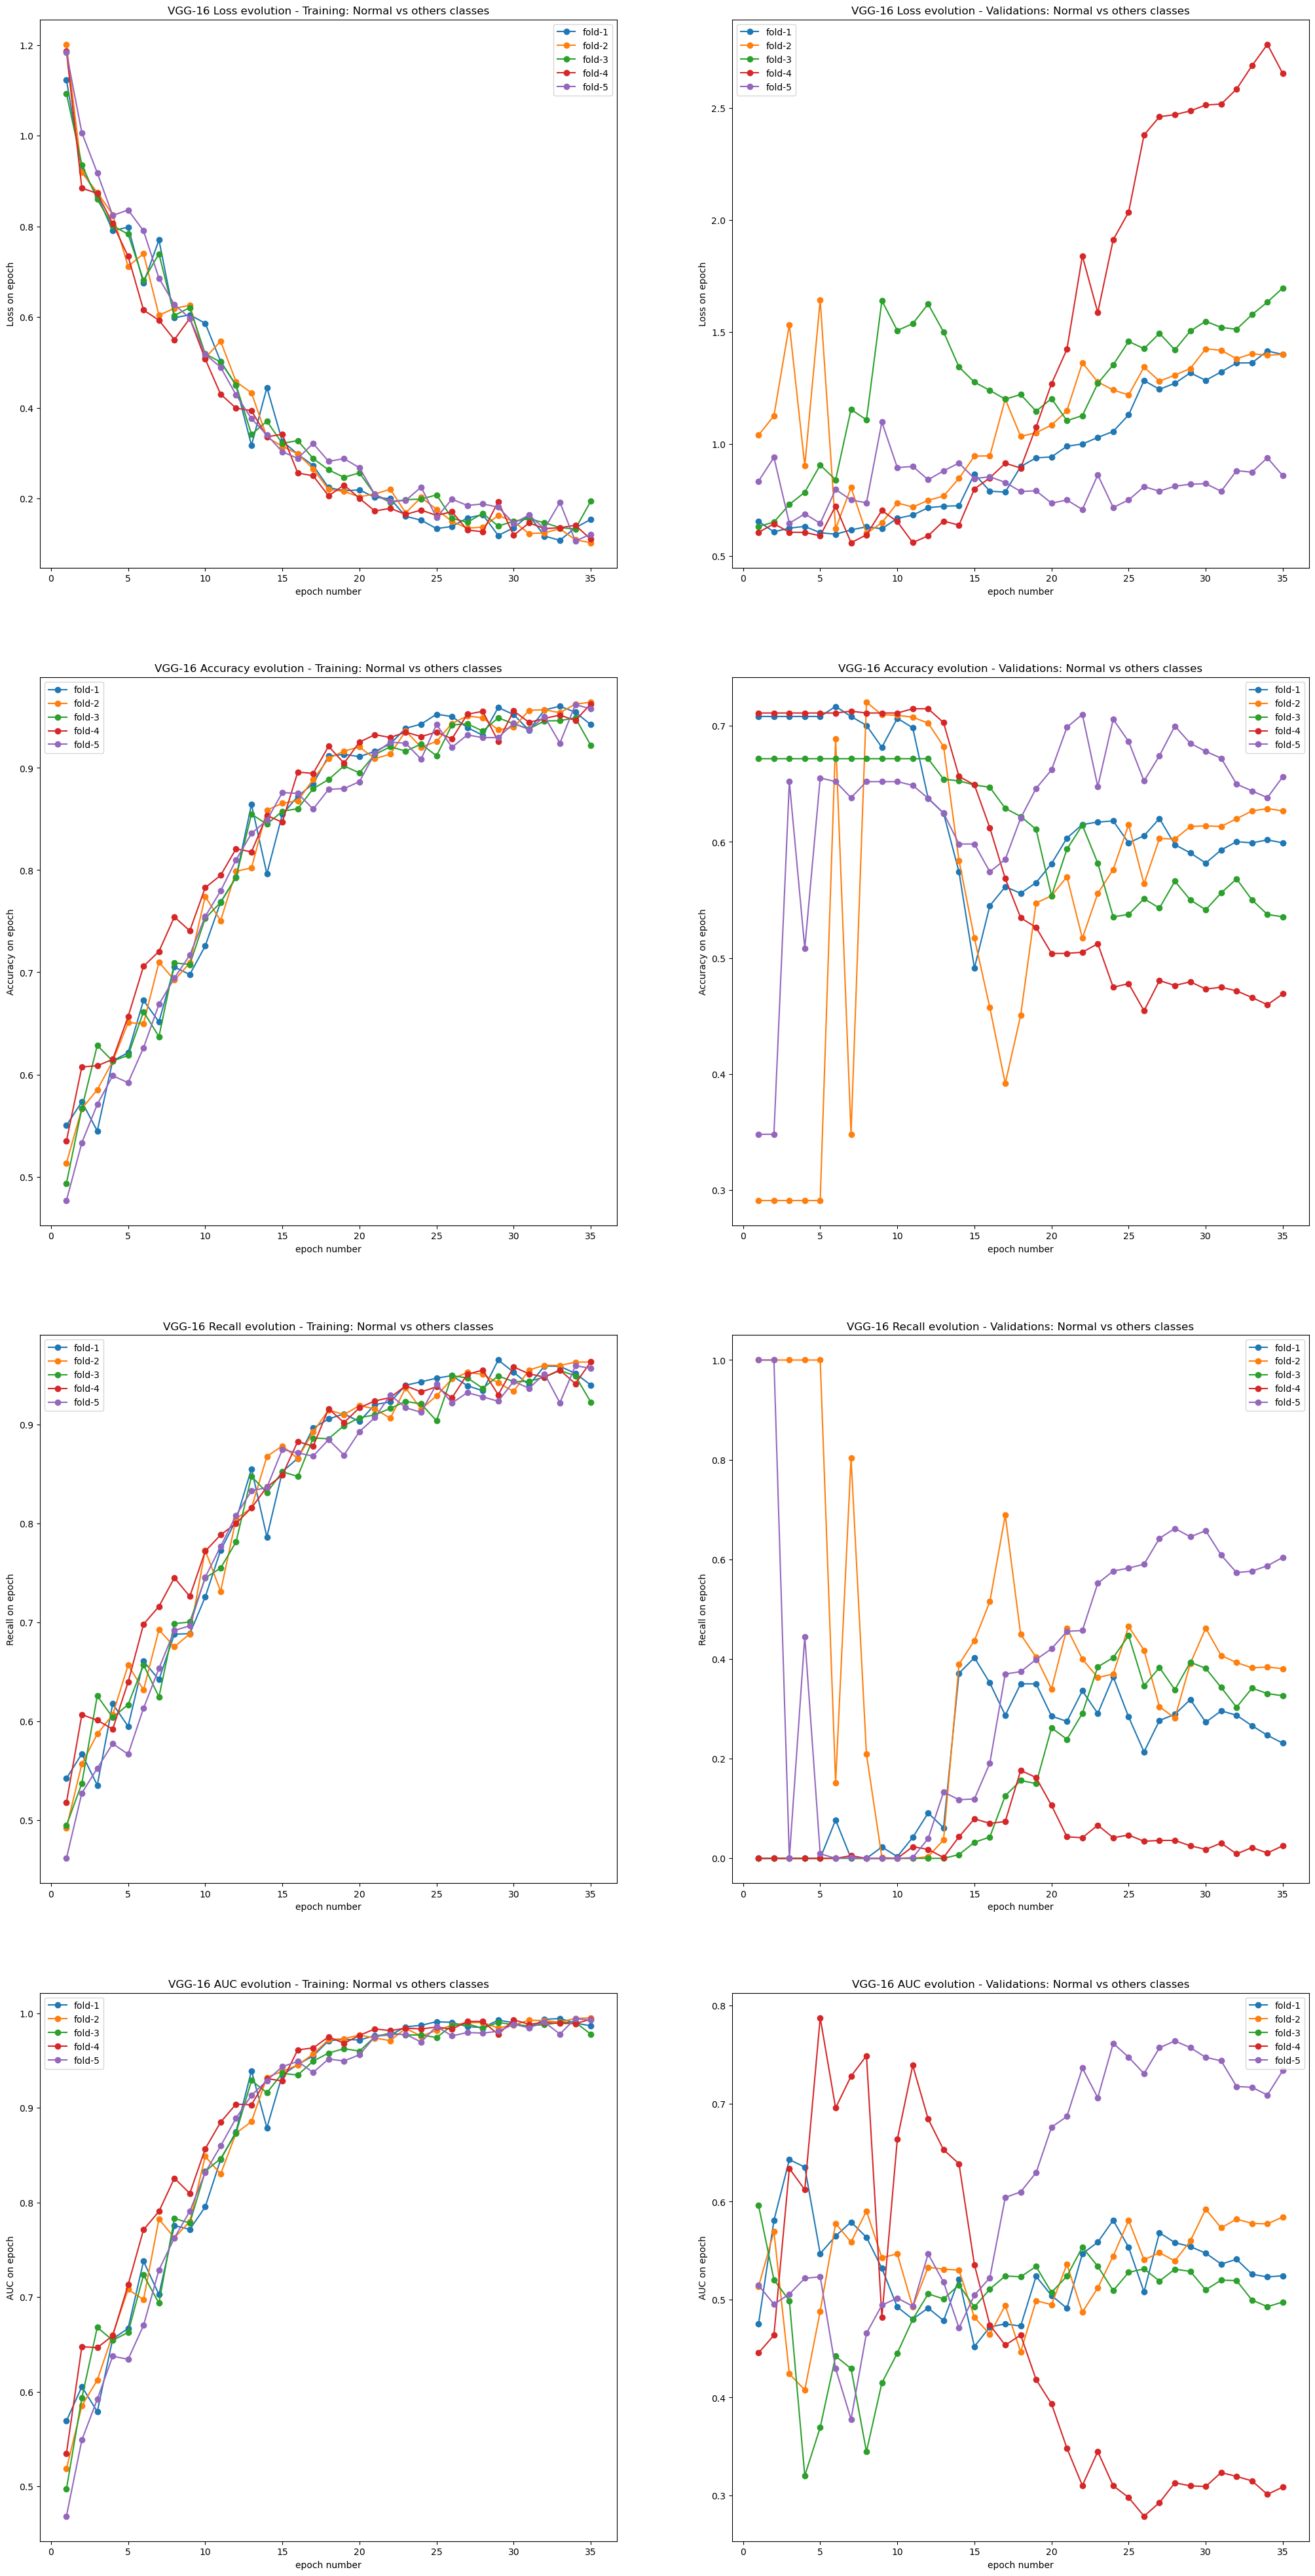

In [ ]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o')
    plt.title('VGG-19 Loss evolution - Training: Normal vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Loss on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o')
    plt.title('VGG-19 Loss evolution - Validations: Normal vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Loss on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 3)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o')
    plt.title('VGG-19 Accuracy evolution - Training: Normal vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 4)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o')
    plt.title('VGG-19 Accuracy evolution - Validations: Normal vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 5)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o')
    plt.title('VGG-19 Recall evolution - Training: Normal vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Recall on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 6)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o')
    plt.title('VGG-19 Recall evolution - Validations: Normal vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Recall on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 7)
for i, h in enumerate(histories):
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o')
    plt.title('VGG-19 AUC evolution - Training: Normal vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('AUC on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 8)
for i, h in enumerate(histories):
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o')
    plt.title('VGG-19 AUC evolution - Validations: Normal vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('AUC on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [ ]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')

    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")


Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 0.9942947030067444
Best Accuracy in train: 0.9603335857391357
Best Precision in train: 0.9615384340286255
Best Recall in train: 0.9653379321098328

VALIDATION RESULTS:
Best AUC in validation: 0.6429274082183838
Best Accuracy in validation: 0.7167689204216003
Best Precision in validation: 0.6197183132171631
Best Recall in validation: 0.40280210971832275


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 0.9949769973754883
Best Accuracy in train: 0.9642623662948608
Best Precision in train: 0.9650349617004395
Best Recall in train: 0.963350772857666

VALIDATION RESULTS:
Best AUC in validation: 0.5923566818237305
Best Accuracy in validation: 0.7203913331031799
Best Precision in validation: 1.0
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 0.9902147054672241
Best Accuracy in train: 0.9489818811416626
Best Precision in train: 0.9486931562423706
Best Recall in train: 0.95

**ACTIONABLE**

In [ ]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1,
                  checkpoint_callback_auc2,
                  checkpoint_callback_auc3,
                  checkpoint_callback_auc4,
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [ ]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]

    # Generators
    training_generator = DataGenerator(objective=[0, 1, 0, 0],
                                       list_IDs=train,
                                       labels_dir='/kaggle/input/labelsssss/labels.csv',
                                       dim_img=(192, 256),
                                       batch_size=4,
                                       sub_batch_size=300,
                                       shuffle=True,
                                       training=True)

    validation_generator = DataGenerator(objective=[0, 1, 0, 0],
                                         list_IDs=val,
                                         labels_dir='/kaggle/input/labelsssss/labels.csv',
                                         dim_img=(192, 256),
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True,
                                         training=False)

    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        vgg19 = get_vgg19()
        vgg19.compile(loss='binary_crossentropy',
                         optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                         metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                                  keras.metrics.BinaryAccuracy(name='accuracy'),
                                  keras.metrics.Precision(name='precision'),
                                  keras.metrics.Recall(name='recall')])


    # Train model on dataset
    histories.append(vgg19.fit(training_generator,
                                   validation_data=validation_generator,
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

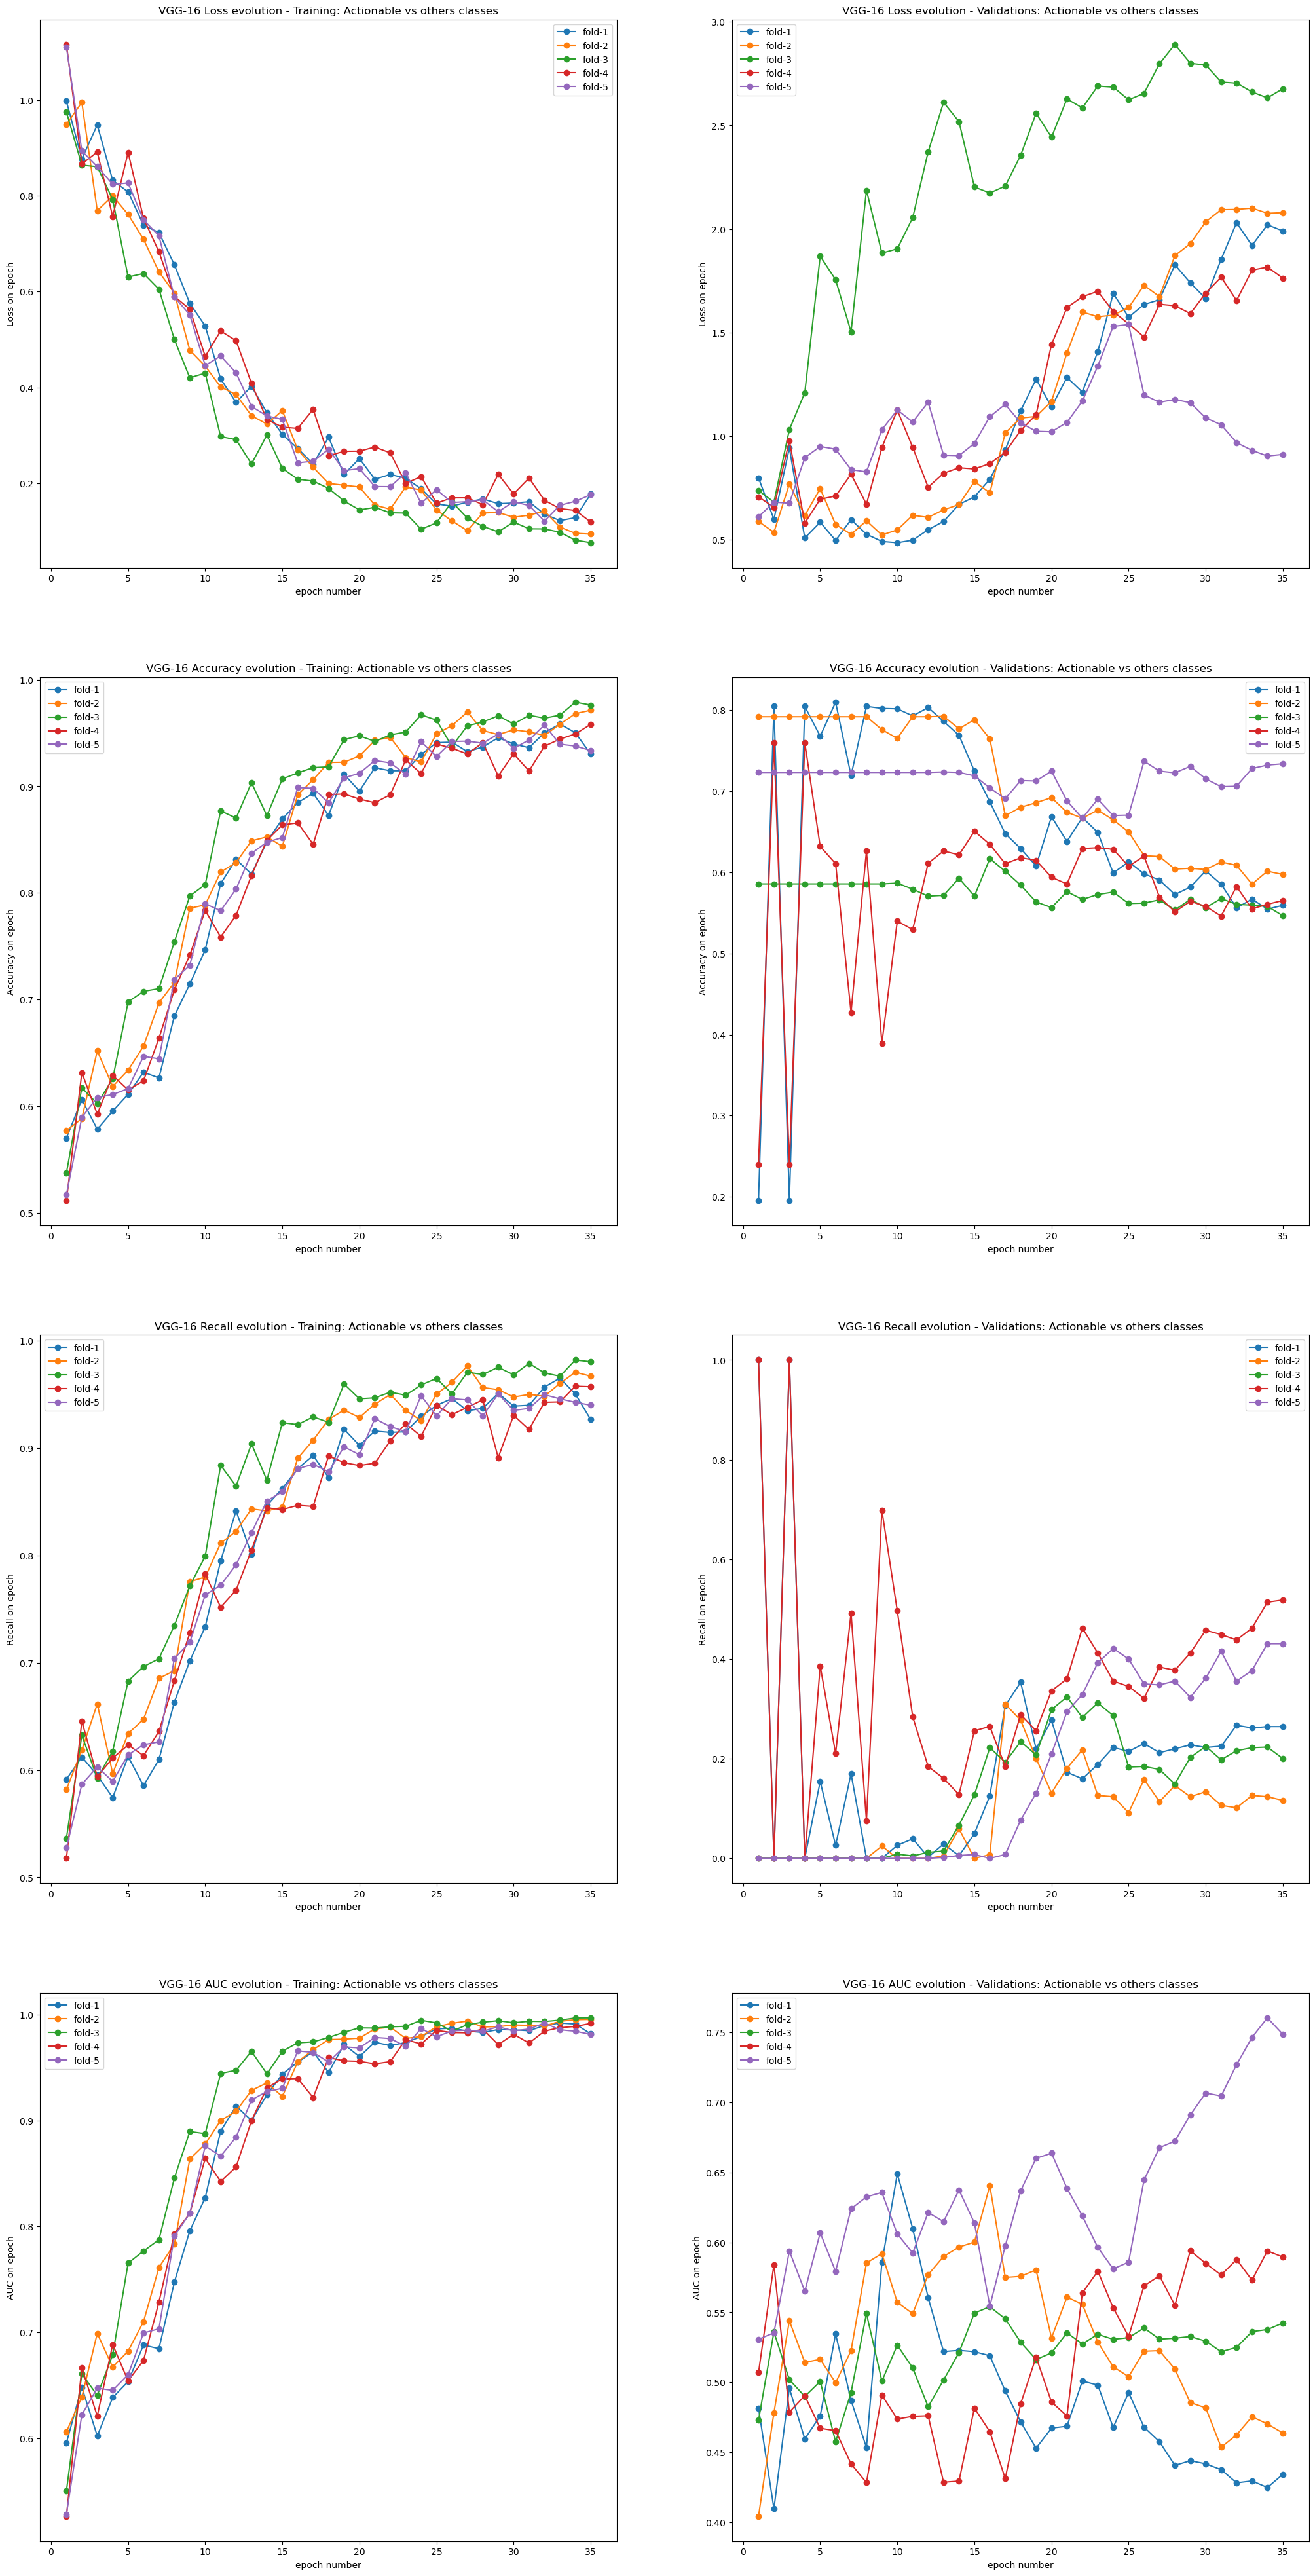

In [ ]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o')
    plt.title('VGG-19 Loss evolution - Training: Actionable vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Loss on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o')
    plt.title('VGG-19 Loss evolution - Validations: Actionable vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Loss on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 3)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o')
    plt.title('VGG-19 Accuracy evolution - Training: Actionable vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 4)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o')
    plt.title('VGG-19 Accuracy evolution - Validations: Actionable vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 5)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o')
    plt.title('VGG-19 Recall evolution - Training: Actionable vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Recall on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 6)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o')
    plt.title('VGG-19 Recall evolution - Validations: Actionable vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Recall on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 7)
for i, h in enumerate(histories):
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o')
    plt.title('VGG-19 AUC evolution - Training: Actionable vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('AUC on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 8)
for i, h in enumerate(histories):
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o')
    plt.title('VGG-19 AUC evolution - Validations: Actionable vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('AUC on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [ ]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')

    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")


Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 0.9923173785209656
Best Accuracy in train: 0.9583446979522705
Best Precision in train: 0.9520474076271057
Best Recall in train: 0.9650464057922363

VALIDATION RESULTS:
Best AUC in validation: 0.6489177942276001
Best Accuracy in validation: 0.8098159432411194
Best Precision in validation: 1.0
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 0.9957069158554077
Best Accuracy in train: 0.9712536334991455
Best Precision in train: 0.9752288460731506
Best Recall in train: 0.976550281047821

VALIDATION RESULTS:
Best AUC in validation: 0.6405330896377563
Best Accuracy in validation: 0.7924819588661194
Best Precision in validation: 0.6666666865348816
Best Recall in validation: 0.30940595269203186


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 0.9971673488616943
Best Accuracy in train: 0.9787914156913757
Best Precision in train: 0.9756662845611572
Best Recall in train: 0.98

**BENIGN**

In [ ]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1,
                  checkpoint_callback_auc2,
                  checkpoint_callback_auc3,
                  checkpoint_callback_auc4,
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [ ]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]

    # Generators
    training_generator = DataGenerator(objective=[0, 0, 1, 0],
                                       list_IDs=train,
                                       labels_dir='/kaggle/input/labelsssss/labels.csv',
                                       dim_img=(192, 256),
                                       batch_size=4,
                                       sub_batch_size=300,
                                       shuffle=True,
                                       training=True)

    validation_generator = DataGenerator(objective=[0, 0, 1, 0],
                                         list_IDs=val,
                                         labels_dir='/kaggle/input/labelsssss/labels.csv',
                                         dim_img=(192, 256),
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True,
                                         training=False)

    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        vgg19 = get_vgg19()
        vgg19.compile(loss='binary_crossentropy',
                         optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                         metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                                  keras.metrics.BinaryAccuracy(name='accuracy'),
                                  keras.metrics.Precision(name='precision'),
                                  keras.metrics.Recall(name='recall')])


    # Train model on dataset
    histories.append(vgg19.fit(training_generator,
                                   validation_data=validation_generator,
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

In [ ]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o')
    plt.title('VGG-19 Loss evolution - Training: Benign vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Loss on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o')
    plt.title('VGG-19 Loss evolution - Validations: Benign vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Loss on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 3)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o')
    plt.title('VGG-19 Accuracy evolution - Training: Benign vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 4)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o')
    plt.title('VGG-19 Accuracy evolution - Validations: Benign vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 5)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o')
    plt.title('VGG-19 Recall evolution - Training: Benign vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Recall on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 6)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o')
    plt.title('VGG-19 Recall evolution - Validations: Benign vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Recall on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 7)
for i, h in enumerate(histories):
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o')
    plt.title('VGG-19 AUC evolution - Training: Benign vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('AUC on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 8)
for i, h in enumerate(histories):
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o')
    plt.title('VGG-19 AUC evolution - Validations: Benign vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('AUC on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [ ]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')

    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")

**CANCER**

In [ ]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1,
                  checkpoint_callback_auc2,
                  checkpoint_callback_auc3,
                  checkpoint_callback_auc4,
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [ ]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]

    # Generators
    training_generator = DataGenerator(objective=[0, 0, 0, 1],
                                       list_IDs=train,
                                       labels_dir='/kaggle/input/labelsssss/labels.csv',
                                       dim_img=(192, 256),
                                       batch_size=4,
                                       sub_batch_size=300,
                                       shuffle=True,
                                       training=True)

    validation_generator = DataGenerator(objective=[0, 0, 0, 1],
                                         list_IDs=val,
                                         labels_dir='/kaggle/input/labelsssss/labels.csv',
                                         dim_img=(192, 256),
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True,
                                         training=False)

    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        vgg19 = get_vgg19()
        vgg19.compile(loss='binary_crossentropy',
                         optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                         metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                                  keras.metrics.BinaryAccuracy(name='accuracy'),
                                  keras.metrics.Precision(name='precision'),
                                  keras.metrics.Recall(name='recall')])


    # Train model on dataset
    histories.append(vgg19.fit(training_generator,
                                   validation_data=validation_generator,
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

In [ ]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o')
    plt.title('VGG-19 Loss evolution - Training: Cancer vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Loss on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o')
    plt.title('VGG-19 Loss evolution - Validations: Cancer vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Loss on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 3)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o')
    plt.title('VGG-19 Accuracy evolution - Training: Cancer vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 4)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o')
    plt.title('VGG-19 Accuracy evolution - Validations: Cancer vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 5)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o')
    plt.title('VGG-19 Recall evolution - Training: Cancer vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Recall on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 6)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o')
    plt.title('VGG-19 Recall evolution - Validations: Cancer vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('Recall on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 7)
for i, h in enumerate(histories):
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o')
    plt.title('VGG-19 AUC evolution - Training: Cancer vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('AUC on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 8)
for i, h in enumerate(histories):
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o')
    plt.title('VGG-19 AUC evolution - Validations: Cancer vs others classes')
    plt.xlabel('epoch number')
    plt.ylabel('AUC on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [ ]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')

    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")

**TESTS**

NORMAL VS OTHERS

In [ ]:
training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                       list_IDs=X_train,
                                       labels_dir='/kaggle/input/labelsssss/labels.csv',
                                       dim_img=(192, 256),
                                       batch_size=4,
                                       sub_batch_size=300,
                                       shuffle=True,
                                       training=True)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    vgg19 = get_vgg19()
    vgg19.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-7),
                  metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
vgg19.load_weights('/kaggle/working/models/normal_auc4/') #start with best AUC in validations
history = vgg19.fit(training_generator, epochs=10)

Epoch 1/10
44/44 [==============================] - 99s 2s/step - loss: 0.7324 - AUC_5: 0.6913 - accuracy: 0.6468 - precision: 0.6505 - recall: 0.6333
Epoch 2/10
44/44 [==============================] - 70s 2s/step - loss: 0.7796 - AUC_5: 0.6935 - accuracy: 0.6441 - precision: 0.6465 - recall: 0.6335
Epoch 3/10
44/44 [==============================] - 67s 2s/step - loss: 0.6812 - AUC_5: 0.7478 - accuracy: 0.6849 - precision: 0.6946 - recall: 0.6584
Epoch 4/10
44/44 [==============================] - 71s 2s/step - loss: 0.6676 - AUC_5: 0.7479 - accuracy: 0.6850 - precision: 0.6908 - recall: 0.6683
Epoch 5/10
44/44 [==============================] - 75s 2s/step - loss: 0.5799 - AUC_5: 0.8068 - accuracy: 0.7352 - precision: 0.7299 - recall: 0.7458
Epoch 6/10
44/44 [==============================] - 70s 2s/step - loss: 0.6008 - AUC_5: 0.8031 - accuracy: 0.7360 - precision: 0.7357 - recall: 0.7357
Epoch 7/10
44/44 [==============================] - 70s 2s/step - loss: 0.6204 - AUC_5: 0.7907

In [ ]:
res = []
for x in X_test:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = vgg19.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]


In [ ]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 0:
        y_true = 0
    else:
        y_true = 1

    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[ 7  6]
 [22 10]]
0.37777777777777777


ACTIONABLE VS OTHERS

In [ ]:
training_generator = DataGenerator(objective=[0, 1, 0, 0],
                                       list_IDs=X_train,
                                       labels_dir='/kaggle/input/labelsssss/labels.csv',
                                       dim_img=(192, 256),
                                       batch_size=4,
                                       sub_batch_size=300,
                                       shuffle=True,
                                       training=True)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    vgg19 = get_vgg19()
    vgg19.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-7),
                  metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
vgg19.load_weights('/kaggle/working/models/actionable_auc5/') #start with best AUC in validations
history = vgg19.fit(training_generator, epochs=10)

Epoch 1/10
44/44 [==============================] - 95s 2s/step - loss: 0.4974 - AUC_5: 0.8906 - accuracy: 0.8141 - precision: 0.8315 - recall: 0.7863
Epoch 2/10
44/44 [==============================] - 75s 2s/step - loss: 0.3896 - AUC_5: 0.9194 - accuracy: 0.8378 - precision: 0.8524 - recall: 0.8162
Epoch 3/10
44/44 [==============================] - 74s 2s/step - loss: 0.3943 - AUC_5: 0.9186 - accuracy: 0.8430 - precision: 0.8825 - recall: 0.7901
Epoch 4/10
44/44 [==============================] - 73s 2s/step - loss: 0.4594 - AUC_5: 0.8941 - accuracy: 0.8098 - precision: 0.8356 - recall: 0.7696
Epoch 5/10
44/44 [==============================] - 76s 2s/step - loss: 0.3406 - AUC_5: 0.9334 - accuracy: 0.8599 - precision: 0.8759 - recall: 0.8379
Epoch 6/10
44/44 [==============================] - 74s 2s/step - loss: 0.3195 - AUC_5: 0.9415 - accuracy: 0.8723 - precision: 0.8859 - recall: 0.8539
Epoch 7/10
44/44 [==============================] - 75s 2s/step - loss: 0.3115 - AUC_5: 0.9445

In [ ]:
res = []
for x in X_test:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = vgg19.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


In [ ]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 1:
        y_true = 0
    else:
        y_true = 1

    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[27  9]
 [ 6  3]]
0.6666666666666666


BENIGN VS OTHERS

In [ ]:
training_generator = DataGenerator(objective=[0, 0, 1, 0],
                                       list_IDs=X_train,
                                       labels_dir='/kaggle/input/labelsssss/labels.csv',
                                       dim_img=(192, 256),
                                       batch_size=4,
                                       sub_batch_size=300,
                                       shuffle=True,
                                       training=True)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    vgg19 = get_vgg19()
    vgg19.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-7),
                  metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
vgg19.load_weights('/kaggle/working/models/benign_auc4/') #start with best AUC in validations
history = vgg19.fit(training_generator, epochs=10)

In [ ]:
res = []
for x in X_test:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = vgg19.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]


In [ ]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 2:
        y_true = 0
    else:
        y_true = 1

    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[28  7]
 [ 6  4]]
0.7111111111111111


CANCER VS OTHERS

In [ ]:
training_generator = DataGenerator(objective=[0, 0, 0, 1],
                                       list_IDs=X_train,
                                       labels_dir='/kaggle/input/labelsssss/labels.csv',
                                       dim_img=(192, 256),
                                       batch_size=4,
                                       sub_batch_size=300,
                                       shuffle=True,
                                       training=True)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    vgg19 = get_vgg19()
    vgg19.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-7),
                  metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
vgg19.load_weights('/kaggle/working/models/cancer_auc3/') #start with best AUC in validations
history = vgg19.fit(training_generator, epochs=10)

In [ ]:
res = []
for x in X_test:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = vgg19.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


In [ ]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 3:
        y_true = 0
    else:
        y_true = 1

    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[ 4  0]
 [35  6]]
0.2222222222222222
